In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConv2D, DepthwiseConv2D
#keras.layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='same', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


In [0]:

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input, merge, UpSampling2D, Cropping2D, ZeroPadding2D, Reshape, core, Convolution2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler


In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [5]:

from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 13s 0us/step


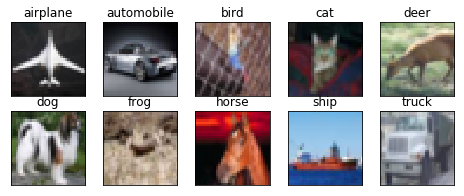

In [6]:

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:

train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [8]:
train_features[0].shape

(32, 32, 3)

In [9]:
num_classes

10

In [0]:

# Shared Input Layer
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D, Conv1D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate, add
from keras import layers


In [0]:
def get_crop_shape(target, refer):
    # width, the 3rd dimension
    cw = (target.get_shape()[2] - refer.get_shape()[2]).value
#     assert (cw >= 0)
    if cw % 2 != 0:
        cw1, cw2 = int(cw/2), int(cw/2) + 1
    else:
        cw1, cw2 = int(cw/2), int(cw/2)
    # height, the 2nd dimension
    ch = (target.get_shape()[1] - refer.get_shape()[1]).value
#     assert (ch >= 0)
    if ch % 2 != 0:
        ch1, ch2 = int(ch/2), int(ch/2) + 1
    else:
        ch1, ch2 = int(ch/2), int(ch/2)

    return (ch1, ch2), (cw1, cw2)

In [0]:
def crop_channel(skip_connection, up_conv):
#     print(skip_connection)
    ch, cw = get_crop_shape(skip_connection, up_conv)
    crop_conv = Cropping2D(cropping=(ch,cw), data_format="channels_last")(skip_connection)
    return crop_conv

In [0]:
def up_down_scalling_and_concat(list_of_concat):
    up_conv = UpSampling2D(size=(2, 2), data_format="channels_last")(list_of_concat[0])
    downscale = [crop_channel(list_of_concat[i], up_conv) for i in range(1, len(list_of_concat))]
    downscale.append(up_conv)
    return concatenate(downscale)

# Segmentation Model ENAS

In [14]:
input = Input(shape=(64,64,3))

#----------------------------------------------block_1-------------------------------------------------------


SepConv_1_1 = SeparableConv2D(64, (5,5), padding="same", activation='relu', dilation_rate=1)(input)
skip_1      = SepConv_1_1

Conv_1_1    = Convolution2D(128, (5,5), padding="same", activation="relu")(SepConv_1_1)
skip_2      = Conv_1_1

Conv_1_2    = Convolution2D(256, (5,5), padding="same", activation="relu")(Conv_1_1)
skip_3      = Conv_1_2

Conv_1_2 = concatenate([Conv_1_2, skip_1])

SepConv_1_2 = SeparableConv2D(64, (5,5), padding="same", activation='relu', dilation_rate=1)(Conv_1_2)
skip_4      = SepConv_1_2

SepConv_1_2 = concatenate([SepConv_1_2, skip_1])
maxpool_1   = MaxPooling2D(pool_size=(2,2))(SepConv_1_2)


#-----------------------------------------------block_2-------------------------------------------------------


SepConv_1_3 = SeparableConv2D(512, (3,3), padding="same", activation='relu', dilation_rate=1)(maxpool_1)
skip_5      = SepConv_1_3

# print(SepConv_1_3.shape, skip_1.shape, skip_4.shape)
SepConv_1_3 = up_down_scalling_and_concat([SepConv_1_3, skip_1, skip_4])

# print(SepConv_1_3.shape)
Conv_1_3    = Convolution2D(512, (5,5), padding="same", activation="relu")(SepConv_1_3)
skip_6      = Conv_1_3

# print(Conv_1_3.shape, skip_3.shape, skip_4.shape)
Conv_1_3 = concatenate([Conv_1_3, skip_3, skip_4]) 
#[Conv_1_3, skip_5, skip_3, skip_4]

SepConv_1_4 = SeparableConv2D(256, (3,3), padding="same", activation='relu', dilation_rate=1)(Conv_1_3)#Conv_1_3
skip_7      = SepConv_1_4

# print(SepConv_1_4.shape, skip_6.shape, skip_3.shape, skip_1.shape, skip_5.shape, skip_4.shape)
SepConv_1_4 = up_down_scalling_and_concat([skip_5, SepConv_1_4, skip_6, skip_3, skip_1, skip_4])
   
SepConv_1_5 = SeparableConv2D(256, (5,5), padding="same", activation='relu', dilation_rate=1)(SepConv_1_4)#SepConv_1_4
skip_8      = SepConv_1_5

# for i in [SepConv_1_5, skip_7 ,skip_5, skip_1, skip_4]:
#     print(i.shape)
SepConv_1_5 = up_down_scalling_and_concat([skip_5, SepConv_1_5, skip_7, skip_1, skip_4])

maxpool_2   = MaxPooling2D(pool_size=(2,2))(SepConv_1_5)


#---------------------------------------------block_3-------------------------------------------------------

# for i in [maxpool_2, skip_6]:
#     print(i.shape)
maxpool_2   = up_down_scalling_and_concat([maxpool_2, skip_6]) 
Conv_1_4    = Convolution2D(128, (5,5), padding="same", activation='relu')(maxpool_2)
skip_9      = Conv_1_4
# for i in [Conv_1_4, skip_7, skip_2, skip_1]:
#     print(i.shape)
Conv_1_4 = concatenate([Conv_1_4, skip_7, skip_2, skip_1])

SepConv_1_6 = SeparableConv2D(128, (5,5), padding="same", activation="relu", dilation_rate=1)(Conv_1_4)
skip_10     = SepConv_1_6

# for i in [SepConv_1_6, skip_5, skip_9, skip_3, skip_2]:
#     print(i.shape)
SepConv_1_6 = up_down_scalling_and_concat([skip_5, SepConv_1_6,  skip_9, skip_3, skip_2])

Conv_1_5 = Convolution2D(64, (3,3), padding= 'same',activation='relu')(SepConv_1_6)
skip_11      = Conv_1_5

# for i in [Conv_1_5, skip_3, skip_7, skip_10, skip_4, skip_5, skip_1]:
#     print(i.shape)
SepConv_1_4 = up_down_scalling_and_concat([skip_5, Conv_1_5, skip_3, skip_7, skip_10, skip_4, skip_1])
# print(SepConv_1_5.)
SepConv_1_7 = SeparableConv2D(32, (5,5), padding='same', activation='relu', dilation_rate=1)(Conv_1_5)
# for i in [SepConv_1_7, skip_7, skip_10, skip_4]:
#     print(i.shape)
SepConv_1_7 = concatenate([SepConv_1_7, skip_7, skip_10, skip_4])

#1x1 convolution 
output = Activation('softmax')(SepConv_1_7)


W0618 06:05:02.165921 140552854841216 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0618 06:05:02.204545 140552854841216 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0618 06:05:02.213570 140552854841216 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0618 06:05:02.308367 140552854841216 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0618 06:05:02.340300 140552854841216 deprecation_wrapp

In [15]:

model = Sequential()

model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 64, 64, 64)   331         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 128)  204928      separable_conv2d_1[0][0]         
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 256)  819456      conv2d_1[0][0]                   
__________________________________________________________________________________________________
concatenat

In [0]:
def max_pool(down_conv):
    return MaxPooling2D(pool_size=(2,2))(down_conv)

In [0]:

def max_pool_two_times(down_conv):
    down_conv = MaxPooling2D(pool_size=(2,2))(down_conv)
    return MaxPooling2D(pool_size=(2,2))(down_conv)

In [0]:
def down_scalling_and_concat(list_of_concat):
    up_conv = list_of_concat[0]
    downscale = [max_pool(list_of_concat[i]) for i in range(1, len(list_of_concat))]
    downscale.append(up_conv)
    return concatenate(downscale)

#  Classification Model ENAS

In [19]:
input = Input(shape=(32, 32, 3))

#----------------------------------------------block_1-------------------------------------------------------

SepConv_1_1 = SeparableConv2D(64, (5,5), padding="same", activation='relu', dilation_rate=1)(input)
SepConv_1_1 = BatchNormalization()(SepConv_1_1)
skip_1      = SepConv_1_1

Conv_1_1    = Convolution2D(128, (5,5), padding="same", activation="relu")(SepConv_1_1)
Conv_1_1 = BatchNormalization()(Conv_1_1)
skip_2      = Conv_1_1

Conv_1_2    = Convolution2D(256, (5,5), padding="same", activation="relu")(Conv_1_1)
Conv_1_2 = BatchNormalization()(Conv_1_2)
skip_3      = Conv_1_2

Conv_1_2 = concatenate([Conv_1_2, skip_1])
SepConv_1_2 = SeparableConv2D(256, (5,5), padding="same", activation='relu', dilation_rate=1)(Conv_1_2)
SepConv_1_2 = BatchNormalization()(SepConv_1_2)
skip_4      = SepConv_1_2

SepConv_1_2 = concatenate([SepConv_1_2, skip_1])
maxpool_1   = MaxPooling2D(pool_size=(2,2))(SepConv_1_2)


#-----------------------------------------------block_2-------------------------------------------------------


SepConv_1_3 = SeparableConv2D(512, (3,3), padding="same", activation='relu', dilation_rate=1)(maxpool_1)
SepConv_1_3 = BatchNormalization()(SepConv_1_3)
skip_5      = SepConv_1_3

# print(SepConv_1_3.shape, skip_1.shape, skip_4.shape)
SepConv_1_3 = concatenate([SepConv_1_3, max_pool(skip_1), max_pool(skip_4)])
Conv_1_3    = Convolution2D(512, (5,5), padding="same", activation="relu")(SepConv_1_3)
Conv_1_3 = BatchNormalization()(Conv_1_3)
skip_6      = Conv_1_3

# print(Conv_1_3.shape, skip_3.shape, skip_4.shape)
Conv_1_3 = concatenate([Conv_1_3, max_pool(skip_3), max_pool(skip_4)]) 
SepConv_1_4 = SeparableConv2D(256, (3,3), padding="same", activation='relu', dilation_rate=1)(Conv_1_3)#Conv_1_3
SepConv_1_4 = BatchNormalization()(SepConv_1_4)
skip_7      = SepConv_1_4

# for i in [skip_5, SepConv_1_4,  skip_7, skip_6, skip_4, skip_3, skip_1]:
#     print(i.shape)
SepConv_1_4 = concatenate([skip_5, SepConv_1_4,  skip_7, max_pool(skip_4), skip_6, max_pool(skip_3), max_pool(skip_1)])
SepConv_1_5 = SeparableConv2D(256, (5,5), padding="same", activation='relu', dilation_rate=1)(SepConv_1_4)#SepConv_1_4
SepConv_1_5 = BatchNormalization()(SepConv_1_5)
skip_8      = SepConv_1_5

# for i in [skip_5, skip_1, skip_4]:
#     print(i.shape)
SepConv_1_5 = concatenate([skip_5, max_pool(skip_1), max_pool(skip_4)])
SepConv_1_5 = concatenate([SepConv_1_5, skip_7, skip_8])
maxpool_2   = MaxPooling2D(pool_size=(2,2))(SepConv_1_5)


#---------------------------------------------block_3-------------------------------------------------------

# for i in [maxpool_2, skip_6]:
#     print(i.shape)
maxpool_2   = concatenate([maxpool_2, max_pool(skip_6)]) 
Conv_1_4    = Convolution2D(128, (5,5), padding="same", activation='relu')(maxpool_2)
Conv_1_4 = BatchNormalization()(Conv_1_4)
skip_9      = Conv_1_4
# for i in [Conv_1_4, skip_7, skip_2, skip_1]:
#     print(i.shape)
Conv_1_4 = concatenate([Conv_1_4, max_pool(skip_7), max_pool_two_times(skip_2), max_pool_two_times(skip_1)])
SepConv_1_6 = SeparableConv2D(128, (5,5), padding="same", activation="relu", dilation_rate=1)(Conv_1_4)
SepConv_1_6 = BatchNormalization()(SepConv_1_6)
skip_10     = SepConv_1_6

# for i in [skip_5, SepConv_1_6,  skip_9, skip_3, skip_2]:
#     print(i.shape)
SepConv_1_6 = concatenate([max_pool(skip_5), SepConv_1_6,  skip_9, max_pool_two_times(skip_3), max_pool_two_times(skip_2)])
Conv_1_5 = Convolution2D(64, (3,3), padding= 'same',activation='relu')(SepConv_1_6)
Conv_1_5 = BatchNormalization()(Conv_1_5)
skip_11      = Conv_1_5

# for i in [skip_5, Conv_1_5, skip_3, skip_7, skip_10, skip_4, skip_1]:
#     print(i.shape)
SepConv_1_4 = concatenate([max_pool(skip_5), Conv_1_5, max_pool_two_times(skip_3), max_pool(skip_7), skip_10, max_pool_two_times(skip_4), max_pool_two_times(skip_1)])
SepConv_1_7 = SeparableConv2D(32, (5,5), padding='same', activation='relu', dilation_rate=1)(Conv_1_5)
SepConv_1_7 = BatchNormalization()(SepConv_1_7)

# for i in [SepConv_1_7, skip_7, skip_10, skip_4]:
#     print(i.shape)
SepConv_1_7 = concatenate([SepConv_1_7, max_pool(skip_7), skip_10, max_pool_two_times(skip_4)])

# output = Flatten()(SepConv_1_7)
# output = Dense(10, activation='softmax')(output)

kk = Convolution2D(32, (1,1), activation='relu')(SepConv_1_7)
kk = Convolution2D(16, (8,8), activation='relu')(kk)
kk = BatchNormalization()(kk)
kk = Convolution2D(10, (1,1), activation='relu')(kk)
kk = Activation('softmax')(kk)
kk = Flatten()(kk)
output = kk

W0618 06:05:02.992052 140552854841216 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0618 06:05:02.993282 140552854841216 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0618 06:05:06.184079 140552854841216 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.



In [20]:
model = Sequential()
model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_8 (SeparableCo (None, 32, 32, 64)   331         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 64)   256         separable_conv2d_8[0][0]         
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 32, 32, 128)  204928      batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [21]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

W0618 06:05:07.694085 140552854841216 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
# model.fit(train_features, train_labels, epochs=50 ,validation_data=(test_features, test_labels))

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 32),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=1562, epochs=100)`
  if sys.path[0] == '':
W0618 06:05:07.911884 140552854841216 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and wi

Epoch 1/100
1562/1562 [==============================] - 276s 177ms/step - loss: 1.3240 - acc: 0.5464 - val_loss: 1.2405 - val_acc: 0.5933
Epoch 2/100
1562/1562 [==============================] - 268s 172ms/step - loss: 0.7769 - acc: 0.7318 - val_loss: 0.7437 - val_acc: 0.7441
Epoch 3/100
1562/1562 [==============================] - 267s 171ms/step - loss: 0.5810 - acc: 0.8035 - val_loss: 0.6382 - val_acc: 0.7814
Epoch 4/100
1562/1562 [==============================] - 267s 171ms/step - loss: 0.4364 - acc: 0.8509 - val_loss: 0.6564 - val_acc: 0.7763
Epoch 5/100
1562/1562 [==============================] - 267s 171ms/step - loss: 0.3162 - acc: 0.8930 - val_loss: 0.6267 - val_acc: 0.8067
Epoch 6/100
1562/1562 [==============================] - 266s 170ms/step - loss: 0.2163 - acc: 0.9280 - val_loss: 0.5479 - val_acc: 0.8328
Epoch 7/100
1562/1562 [==============================] - 266s 170ms/step - loss: 0.1514 - acc: 0.9487 - val_loss: 0.6038 - val_acc: 0.8227
Epoch 8/100
1562/1562 [====

In [0]:
# train_labels